In [14]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from data_managment import datasets, nuscenes, frontcam 
from data_managment.data_modules import LidarTokenizerModule
from model_managment.helpers import load_model

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

import matplotlib
import numpy as np
import plotly.graph_objects as go
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl


In [15]:
configs = ["../model_managment/config_FINAL_ld_curves.yaml",
               "../model_managment/config_FINAL_ld_reinit.yaml",
               "../model_managment/config_FINAL_ld_fsq.yaml",
               "../model_managment/config_FINAL_ld_fsq_1k.yaml",
               "../model_managment/config_FINAL_ld_fsq_4k.yaml"]

models = ["../slurm_logs/ld_FINAL_baseline_241113_2331/models/lidar-diffusion-epoch=34-step=39999.ckpt",
            "../slurm_logs/ld_FINAL_reinit_241114_1057/models/lidar-diffusion-epoch=34-step=39999.ckpt",
            "../slurm_logs/ld_FINAL_fsq_241114_1121/models/lidar-diffusion-epoch=34-step=39999.ckpt",
            "../slurm_logs/ld_FINAL_fsq_1k_241117_1213/models/lidar-diffusion-epoch=34-step=39999.ckpt",
            "../slurm_logs/ld_FINAL_fsq_4k_241117_1216/models/lidar-diffusion-epoch=34-step=39999.ckpt"]

assert len(configs) == len(models)

In [ ]:
# BIG PLOT FOR ONE MODEL

k = 4 # number of model from above lists
model = load_model(configs[k])
checkpoint = torch.load(models[k], map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

data = LidarTokenizerModule(dataroot = '/data/',
                      batch_size = 1,
                      num_workers = 0,
                      info_file_path = "../data_managment/nuscenes_info_plot.json",    # specifies which files are train/val/test
                      mode="range_image",
                      dataset="nuscenes",
                      config_path=configs[k][3:],
                      version="v1.0-test"
                      )   

trainer = pl.Trainer(gpus=0)
predictions = trainer.predict(model, datamodule=data)

print(f" Range img MSE: {round(float(predictions[0]['test_img_mse'][0]),3)}")
print(f" Range img MAE: {round(float(predictions[0]['test_img_mae'][0]),3)}")
print(f"Pointcloud MSE: {round(float(predictions[0]['test_points_mse'][0]),3)}")
print(f"Pointcloud MAE: {round(float(predictions[0]['test_points_mae'][0]),3)}")

imgs = [
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT_LEFT/n008-2018-08-31-12-15-24-0400__CAM_FRONT_LEFT__1535732714904799.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT_LEFT/n008-2018-08-30-10-33-52-0400__CAM_FRONT_LEFT__1535639756404799.jpg",
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT/n008-2018-08-31-12-15-24-0400__CAM_FRONT__1535732714912404.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639756412404.jpg",
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT_RIGHT/n008-2018-08-31-12-15-24-0400__CAM_FRONT_RIGHT__1535732714920482.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_FRONT_RIGHT/n008-2018-08-30-10-33-52-0400__CAM_FRONT_RIGHT__1535639756420482.jpg",
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK_RIGHT/n008-2018-08-31-12-15-24-0400__CAM_BACK_RIGHT__1535732714928113.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK_RIGHT/n008-2018-08-30-10-33-52-0400__CAM_BACK_RIGHT__1535639756428113.jpg",
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK/n008-2018-08-31-12-15-24-0400__CAM_BACK__1535732714937558.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK/n008-2018-08-30-10-33-52-0400__CAM_BACK__1535639756437558.jpg",
        "/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK_LEFT/n008-2018-08-31-12-15-24-0400__CAM_BACK_LEFT__1535732714947405.jpg",#"/mnt/data/Public_datasets/nuScenes/samples/CAM_BACK_LEFT/n008-2018-08-30-10-33-52-0400__CAM_BACK_LEFT__1535639756447405.jpg",
 ]

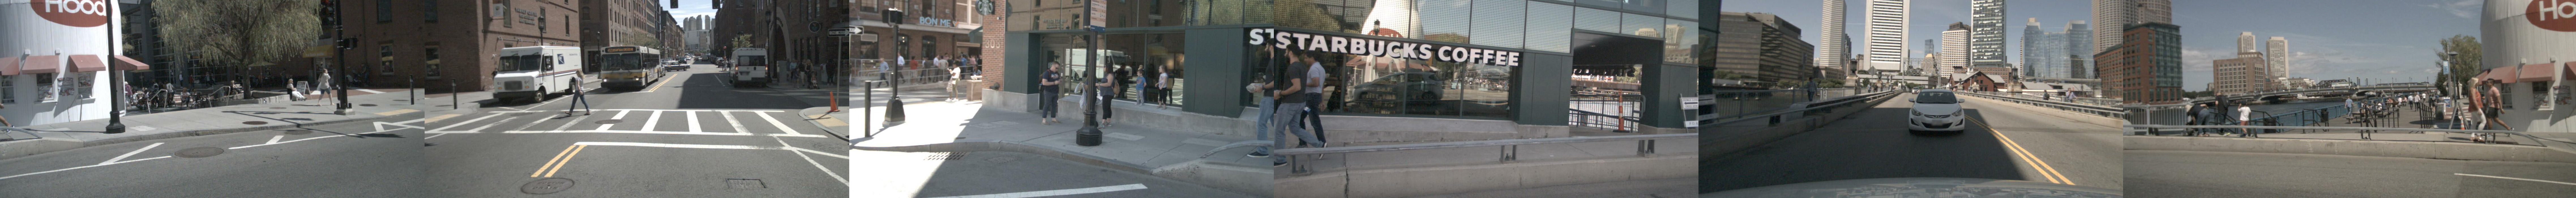

/tmp/ipykernel_882021/2257257123.py:104: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



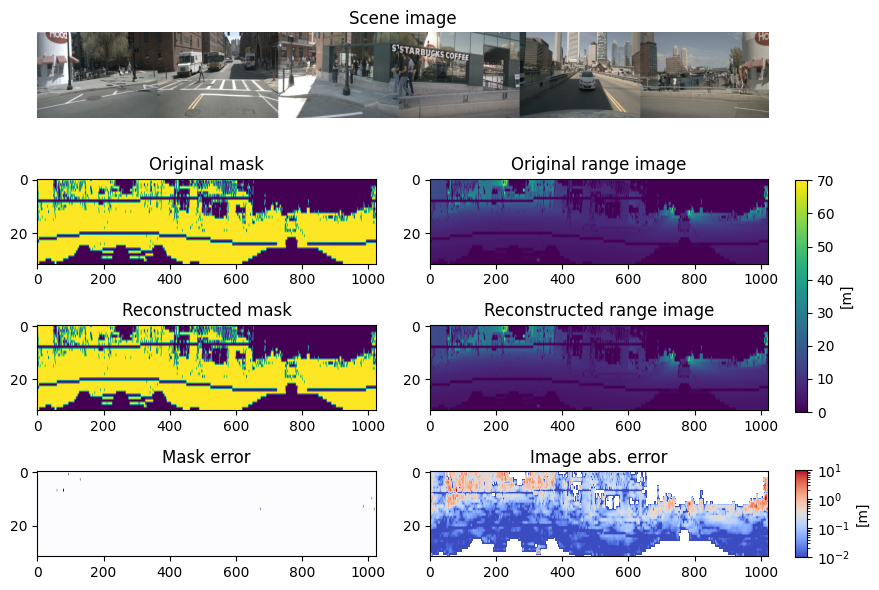

In [17]:
# BIG PLOT

i = 0

data_config = data.data_config['model']['params']['lossconfig']['params']['dataset_config']

x = predictions[i]['x'][0]
x = x*0.5 + 0.5
x = x*data_config['depth_scale']
if data_config['log_scale']:
    x = np.exp2(x) - 1

x_rec = predictions[i]['x_rec'][0] 
x_rec = x_rec*0.5 + 0.5
x_rec = x_rec*data_config['depth_scale']
if data_config['log_scale']:
    x_rec = np.exp2(x_rec) - 1

m = predictions[i]['m'][0]
m_rec = predictions[i]['m_rec'][0]
m_rec[np.argwhere(m_rec<=0)[0], np.argwhere(m_rec<=0)[1]] = -1
m_rec[np.argwhere(m_rec>0)[0], np.argwhere(m_rec>0)[1]] = 1

x_masked = x.copy()
x_masked[np.argwhere(m<0)[0], np.argwhere(m<0)[1]] = -1

x_rec_masked = x_rec.copy()
x_rec_masked[np.argwhere(m_rec<0)[0], np.argwhere(m_rec<0)[1]] = -1

m_rec_err_abs = np.abs(m-m_rec)
x_rec_err_abs = np.abs(x-x_rec)
x_masked_rec_err_abs = np.abs(x_masked-x_rec_masked)

#m_rec_err_rel = np.abs(m-m_rec)/np.abs(m)
#x_rec_err_rel = np.abs(x-x_rec)/np.abs(x)
#x_masked_rec_err_rel = np.abs(x_masked-x_rec_masked)/np.abs(x_masked)

x_rec_err_abs[np.argwhere(m<0)[0], np.argwhere(m<0)[1]] = 0

vmin = -1#min(x.min(), x_rec.min(), x_masked.min(), x_rec_masked.min())
vmax = 1#max(x.max(), x_rec.max(), x_masked.max(), x_rec_masked.max())
#vmax_err = max(x_rec_err_abs.max(), x_masked_rec_err_abs.max())

fig, axes = plt.subplots(4, 2, figsize=(8, 6))

axes[0, 0].remove()
axes[0, 1].remove()
big_ax = fig.add_subplot(4, 1, 1)

axes[1,0].imshow(m, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axes[1,0].set_title('Original mask')

axes[1,1].imshow(x, aspect='auto', cmap='viridis', vmin=0, vmax=70)
axes[1,1].set_title('Original range image')

axes[2,0].imshow(m_rec, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axes[2,0].set_title('Reconstructed mask')

im3 = axes[2,1].imshow(x_rec, aspect='auto', cmap='viridis', vmin=0, vmax=70)
axes[2,1].set_title('Reconstructed range image')

axes[3,0].imshow(m_rec_err_abs, aspect='auto', cmap='Purples', vmin=0, vmax=1)
axes[3,0].set_title('Mask error')

im8 = axes[3,1].imshow(x_rec_err_abs, aspect='auto', cmap='coolwarm', norm=matplotlib.colors.LogNorm(vmin=0.01,vmax=10))
axes[3,1].set_title('Image abs. error')


plt.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([1, 0.305, 0.015, 0.386])  # [left, bottom, width, height]
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label("[m]")

cbar_ax_2 = fig.add_axes([1, 0.063, 0.015, 0.145])  # [left, bottom, width, height]
cbar_2 = fig.colorbar(im8, cax=cbar_ax_2)
cbar_2.set_label("[m]")


if data.dataset_name == "nuscenes":
    # STITCHED IMAGE
    images = [Image.open(img_path) for img_path in imgs]

    total_width = sum(img.width for img in images) - 100 * (len(images) - 1)
    max_height = max(img.height for img in images)  # Height of the tallest image

    stitched_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for i, img in enumerate(images):
        stitched_image.paste(img, (x_offset, 0)) 
        x_offset += img.width - 100  

    cropped_image = stitched_image.crop((0, 200, total_width, max_height))

    cropped_image.show()  

    big_ax.imshow(cropped_image, aspect='auto')
    big_ax.set_title('Scene image')
    big_ax.axis('off')  
else:
    pass

plt.tight_layout()
plt.show()

In [18]:
import plotly.io as pio
pio.renderers.default = 'browser'

i = 0

fig = go.Figure(data=[go.Scatter3d(
    x=predictions[i]['pcd_rec'][0][:,0],
    y=predictions[i]['pcd_rec'][0][:,1],
    z=predictions[i]['pcd_rec'][0][:,2],
    mode='markers',
    marker=dict(size=2, color='blue')
)])

fig.add_trace(go.Scatter3d(
    x=predictions[i]['pcd_rec_masked'][0][:,0],
    y=predictions[i]['pcd_rec_masked'][0][:,1],
    z=predictions[i]['pcd_rec_masked'][0][:,2],
    mode='markers',
    marker=dict(size=2, color='green')  # Set color for the second point cloud
))

fig.add_trace(go.Scatter3d(
    x=predictions[i]['pcd'][0][:,0],
    y=predictions[i]['pcd'][0][:,1],
    z=predictions[i]['pcd'][0][:,2],
    mode='markers',
    marker=dict(size=2, color='red')  # Set color for the second point cloud
))

errors = np.linalg.norm(predictions[i]['pcd_rec_ground_truth_masked'][0] - predictions[i]['pcd'][0],axis=1)
log_errors = np.log10(errors)

cmin = -2.5
cmax = max(log_errors)

tickvals = np.logspace(cmin, cmax, 5)
ticktext = [f"{val:.4f}" for val in tickvals]
actual_tickvals = np.linspace(cmin, cmax,5)

fig.add_trace(go.Scatter3d(
    x=predictions[i]['pcd_rec_ground_truth_masked'][0][:,0],
    y=predictions[i]['pcd_rec_ground_truth_masked'][0][:,1],
    z=predictions[i]['pcd_rec_ground_truth_masked'][0][:,2],
    mode='markers',
    marker=dict(size=3, color=log_errors,  # Use log-transformed errors for coloring
        colorscale='balance',  # Colormap
        colorbar=dict(
            title='Error (log scale, meters)',
            tickvals=actual_tickvals,  # Log scale tick marks
            ticktext=ticktext,
            len=0.7
        ),
        cmin=cmin, 
        cmax=cmax, 
    )
))


all_points = np.concatenate([predictions[i]['pcd_rec_masked'][0], predictions[i]['pcd'][0]], axis=0)

x_min, y_min, z_min = all_points.min(axis=0)
x_max, y_max, z_max = all_points.max(axis=0)

range_min = min(x_min.item(), y_min.item(), z_min.item())
range_max = max(x_max.item(), y_max.item(), z_max.item())

""" camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=-8, z=-1),
    eye=dict(x=1.25, y=1.25, z=1.25)
) """

fig.update_layout(
    #scene_camera=camera,
    scene=dict(
        xaxis=dict(nticks=10, range=[range_min, range_max], backgroundcolor="white"),
        yaxis=dict(nticks=10, range=[range_min, range_max], backgroundcolor="white"),
        zaxis=dict(nticks=10, range=[range_min, range_max], backgroundcolor="white"),
        aspectmode='cube'
    ),
    paper_bgcolor="white",  # Background color outside the 3D scene
    plot_bgcolor="white"    # Background color inside the 3D scene
)

fig.show()

/tmp/ipykernel_882021/1608857872.py:31: RuntimeWarning:

divide by zero encountered in log10

